# Day 17 – Evaluation & Validation
### Avoiding Overfitting with Cross-Validation (SaaS Churn Model)

Building on Day 16’s model training, we now focus on how to **evaluate**, **validate**, and **trust** our predictions.

#### Goals:
- Understand overfitting and how to detect it
- Apply k-fold cross-validation to Random Forest
- Compare training vs validation performance
- Visualize ROC Curve for classification quality
- Interpret results for business insights

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load and Prepare Dataset

In [2]:
# Load real-world Telco Churn dataset
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

# Convert TotalCharges to numeric, drop missing
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Encode Churn column (Yes/No → 1/0)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Encode contract type (Month-to-month, 1 year, 2 year)
df['ContractType_Code'] = df['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
df.rename(columns={'Contract': 'ContractType'}, inplace=True)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ContractType_Code
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0


## 2. Feature Selection and Data Split

In [4]:
# Select features - numerical and categorical
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = ['ContractType', 'InternetService', 'OnlineSecurity', 'TechSupport', 'PaymentMethod']

# One-hot encode categorical features
X_categorical = pd.get_dummies(df[categorical_features], drop_first=True)

# Combine numerical and encoded categorical features
X = pd.concat([df[numerical_features], X_categorical], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Train Base Model (Random Forest)

In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Metrics
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc*100:.2f}%\n")
print(classification_report(y_test, y_pred))

Model Accuracy: 77.76%

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1291
           1       0.60      0.50      0.55       467

    accuracy                           0.78      1758
   macro avg       0.71      0.69      0.70      1758
weighted avg       0.77      0.78      0.77      1758



## 4. K-Fold Cross-Validation

Cross-Validation Scores: [0.76966825 0.76777251 0.77819905 0.77725118 0.80170778]
Mean CV Accuracy: 77.89% ± 1.21%


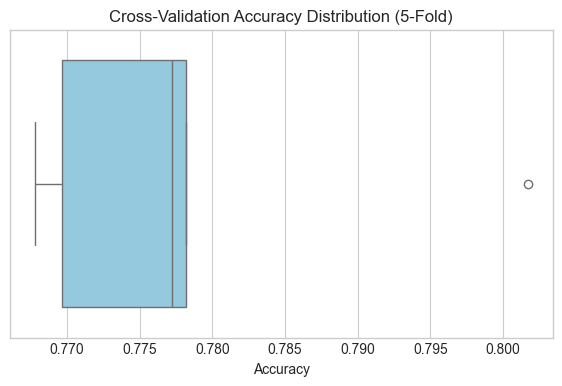

In [8]:
# Perform 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")

# Plot accuracy distribution
plt.figure(figsize=(7,4))
sns.boxplot(x=cv_scores, color='skyblue')
plt.title('Cross-Validation Accuracy Distribution (5-Fold)')
plt.xlabel('Accuracy')
plt.show()

### 🔍 Insight
- CV gives us a **distribution** of performance across folds.
- A small standard deviation → stable model.
- If variance is high → possible overfitting or data leakage.

## 5. Compare Training vs Validation Accuracy (Overfitting Check)

Training Accuracy: 99.47%
Validation Accuracy: 77.76%


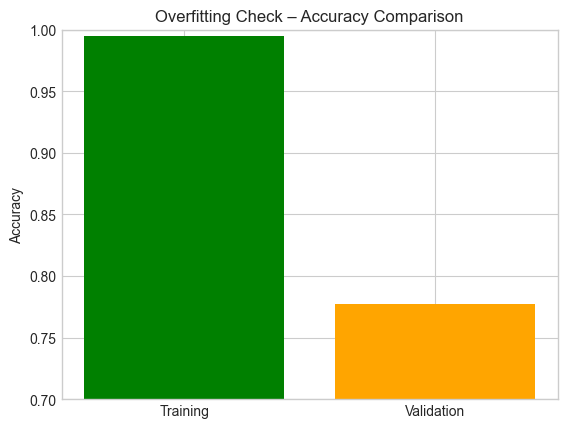

In [9]:
train_acc = model.score(X_train_scaled, y_train)
val_acc = acc
print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")

plt.bar(['Training', 'Validation'], [train_acc, val_acc], color=['green', 'orange'])
plt.ylim(0.7, 1.0)
plt.title('Overfitting Check – Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

### 💡 Observation
- If **training accuracy >> validation accuracy**, the model may be overfitting.
- Random Forest typically generalizes well, but still needs tuning (coming in Day 18).

## 6. Confusion Matrix and ROC Curve

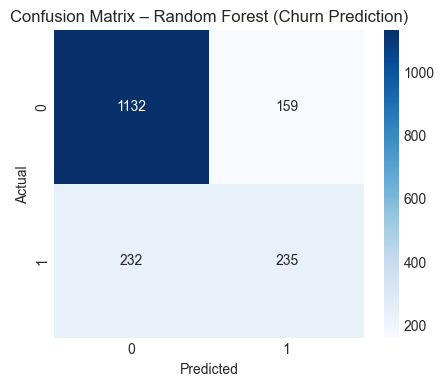

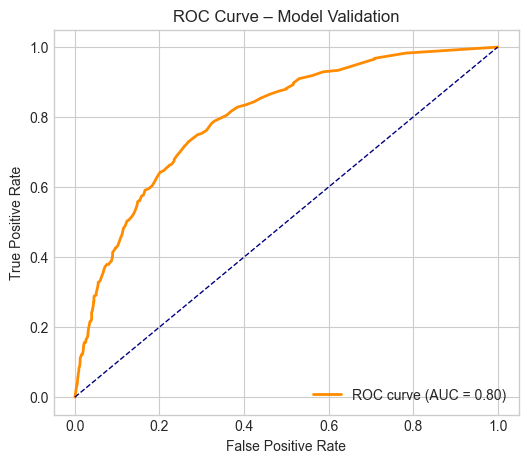

In [10]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Random Forest (Churn Prediction)')
plt.show()

# ROC Curve
y_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Model Validation')
plt.legend(loc='lower right')
plt.show()

### 🔍 ROC-AUC Interpretation
- **AUC > 0.8** indicates good model separability between churn and non-churn.
- The ROC curve shows the trade-off between **sensitivity (recall)** and **specificity (false positives)**.

## 7. Business Takeaways
- Consistent CV performance = trustworthy predictions across customer groups.
- ROC-AUC confirms model robustness in detecting churn risk.
- Overfitting check ensures predictions generalize beyond training data.

🧠 *In production, validation ensures your model makes reliable predictions before deployment.*

## ✅ Summary
- Applied **k-fold cross-validation** for robust evaluation.
- Visualized performance consistency & overfitting risks.
- Used ROC-AUC to measure predictive separability.
- Ready for **hyperparameter tuning** (Day 18) to optimize model further.

**Deliverable:** `day17_evaluation_validation.ipynb`